In [1]:
# -*- coding: utf-8 -*-
# Author: Inyong Hwang (lkan6004@gmail.com)
# Date: 2019-06-17-Mon
# Korean Character STR 20*20 by ResNet epoch=1~100 

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
print('=====Google Drive=====')
!ls '/content/drive/My Drive/'
print('=====input=====')
!ls '/content/drive/My Drive/PUBLIC/PROJECT/OCR/STR/PKL_20v4/'

=====Google Drive=====
 논문			      'Colab Notebooks'   Lab-Desktop   PUBLIC
'AI 사물인식 해커톤 (2).zip'   Dataset		  Program       USB
=====input=====
images.pkl  labels.pkl


loading labels.pkl
loaded!
loading images.pkl
loaded!
# of images: 139104
Shape of images: (20, 20, 1)
# of train set: 111283 # of test set: 27821


W0616 14:08:13.837838 139690822580096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Image (InputLayer)        (None, 20, 20, 1)    0                                            
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 20, 20, 16)   160         Input_Image[0][0]                
__________________________________________________________________________________________________
batch_normalization_56 (BatchNo (None, 20, 20, 16)   64          conv2d_59[0][0]                  
__________________________________________________________________________________________________
activation_56 (Activation)      (None, 20, 20, 16)   0           batch_normalization_56[0][0]     
__________________________________________________________________________________________________
conv2d_60 

W0616 14:08:14.990768 139690822580096 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 89026 samples, validate on 22257 samples
Epoch 1/100
Learning rate:  0.001
 - 87s - loss: 3.7707 - acc: 0.4649 - val_loss: 2.1285 - val_acc: 0.6794

Epoch 00001: val_acc improved from -inf to 0.67943, saving model to /content/drive/My Drive/PUBLIC/PROJECT/OCR/STR/COLAB_OUTPUT_6/resnet56v2_1_100_20/checkpoint.001.hg
Epoch 2/100
Learning rate:  0.001
 - 66s - loss: 1.3721 - acc: 0.8361 - val_loss: 1.8390 - val_acc: 0.7133

Epoch 00002: val_acc improved from 0.67943 to 0.71335, saving model to /content/drive/My Drive/PUBLIC/PROJECT/OCR/STR/COLAB_OUTPUT_6/resnet56v2_1_100_20/checkpoint.002.hg
Epoch 3/100
Learning rate:  0.001
 - 67s - loss: 0.9241 - acc: 0.9084 - val_loss: 1.2198 - val_acc: 0.8286

Epoch 00003: val_acc improved from 0.71335 to 0.82859, saving model to /content/drive/My Drive/PUBLIC/PROJECT/OCR/STR/COLAB_OUTPUT_6/resnet56v2_1_100_20/checkpoint.003.hg
Epoch 4/100
Learning rate:  0.001
 - 67s - loss: 0.7220 - acc: 0.9361 - val_loss: 1.7665 - val_acc: 0.7157

Epoch 00

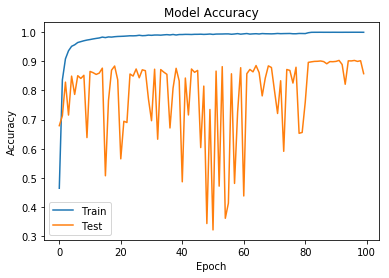

In [4]:
# read directory
import sys
import os
import pickle
import numpy as np
from keras.utils import to_categorical
from collections import Counter
from sklearn.model_selection import train_test_split
from keras import layers
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras.models import Model
from keras import backend as k
import matplotlib.pyplot as plt
import pandas as pd

model_name = 'resnet56v2_1_100_20'
input_dir = '/content/drive/My Drive/PUBLIC/PROJECT/OCR/STR/PKL_20v4/'
output_dir = '/content/drive/My Drive/PUBLIC/PROJECT/OCR/STR/COLAB_OUTPUT_6/'

if os.path.isdir(output_dir):
    pass
else:
    os.mkdir(output_dir)

if os.path.isdir(output_dir + str(model_name)):
    pass
else:
    os.mkdir(output_dir + str(model_name))
   
filenames = os.listdir(input_dir)
for filename in filenames:
    if 'image' in filename:
        print('loading %s' % filename)
        with open(input_dir + filename, 'rb') as f:
            X = pickle.load(f)
        print('loaded!')
    else:
        print('loading %s' % filename)
        with open(input_dir + filename, 'rb') as f:
            Y = pickle.load(f)
        print('loaded!')

X = np.array(X)
X = X[:, :, :, np.newaxis]
input_shape = X.shape[1:]
Y = np.array(Y)
num_classes = len(Counter(Y))
Y = to_categorical(Y, num_classes)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=37, shuffle=True)
print('# of images: %d' % len(X))
print('Shape of images:', X.shape[1:])
print('# of train set: %d' % len(X_train), '# of test set: %d' % len(X_test))
del X, Y

# Define Model
version = 2
n = 6
depth = n * 9 + 2
batch_size = 128
epochs = 100 # 200
model_type = 'ResNet%dv%d' % (depth, version)


def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(filters=filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v2(input_shape=input_shape, depth=depth, classes=num_classes):
    filters_in = 16
    resnet_blocks = int((depth - 2) / 9)

    i = Input(shape=input_shape, name='Input_Image')
    x = resnet_layer(inputs=i, filters=filters_in, conv_first=True)
    for stage in range(3):
        for resnet_block in range(resnet_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                filters_out = filters_in * 4
                if resnet_block == 0:
                    activation = None
                    batch_normalization = False
            else:
                filters_out = filters_in * 2
                if resnet_block == 0:
                    strides = 2
            y = resnet_layer(inputs=x, filters=filters_in, kernel_size=1, strides=strides, activation=activation, batch_normalization=batch_normalization, conv_first=False)
            y = resnet_layer(inputs=y, filters=filters_in, conv_first=False)
            y = resnet_layer(inputs=y, filters=filters_out, kernel_size=1, conv_first=False)
            if resnet_block == 0:
                x = resnet_layer(inputs=x, filters=filters_out, kernel_size=1, strides=strides, activation=None, batch_normalization=False)
            x = layers.add([x, y])
        filters_in = filters_out

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # x = AveragePooling2D(pool_size=8)(x)
    x = Flatten()(x)
    y = Dense(classes, activation='softmax', kernel_initializer='he_normal')(x)
    model = Model(inputs=i, outputs=y)
    return model


model = resnet_v2(input_shape=input_shape, depth=depth)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr_schedule(0)), metrics=['accuracy'])
print(model_type)
checkpoint = ModelCheckpoint(filepath=output_dir + str(model_name) + '/checkpoint.{epoch:03d}.hg',
                             monitor='val_acc',
                             verbose=2,
                             save_best_only=True)
lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]
fit = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=2, callbacks=callbacks, validation_split=0.2, initial_epoch=0)
eva = model.evaluate(X_test, Y_test, verbose=2)


def plot_loss(history, output_dir, model_name):
    plt.clf()
    plt_loss = plt
    plt_loss.plot(history.history['loss'])
    plt_loss.plot(history.history['val_loss'])
    plt_loss.title('Model Loss')
    plt_loss.xlabel('Epoch')
    plt_loss.ylabel('Loss')
    plt_loss.legend(['Train', 'Test'], loc=0)
    figure = output_dir + str(model_name) + '/loss.png'
    plt_loss.savefig(figure, dpi=1080)


def plot_acc(history, output_dir, model_name):
    plt.clf()
    plt_acc = plt
    plt_acc.plot(history.history['acc'])
    plt_acc.plot(history.history['val_acc'])
    plt_acc.title('Model Accuracy')
    plt_acc.xlabel('Epoch')
    plt_acc.ylabel('Accuracy')
    plt_acc.legend(['Train', 'Test'], loc=0)
    figure = output_dir + str(model_name) + '/accuracy.png'
    plt_acc.savefig(figure, dpi=1080)


def csv_fit(history, output_dir, model_name):
    train_data = pd.DataFrame(history.history)
    train_data.to_csv(output_dir + str(model_name) + '/csv_fit.csv')
    return None


def csv_eva(history, output_dir, model_name):
    test_data = pd.DataFrame(history)
    test_data = test_data.T
    if len(history) == 5:
        test_data_header = ['test_loss', 'test_acc', 'precision', 'recall', 'f1score']
    else:
        test_data_header = ['test_loss', 'test_acc']
    test_data.to_csv(output_dir + str(model_name) + '/csv_eva.csv', header=test_data_header)
    return None


print('Model: ', model_name, ', Loss: ', eva[0], ', Accuracy: ', eva[1])
plot_loss(history=fit, output_dir=output_dir, model_name=model_name)
plot_acc(history=fit, output_dir=output_dir, model_name=model_name)
csv_fit(history=fit, output_dir=output_dir, model_name=model_name)
csv_eva(history=eva, output_dir=output_dir, model_name=model_name)
model.save(output_dir + str(model_name) + '/model.h5')
model_json = model.to_json()
with open(output_dir + str(model_name) + '/model.json', 'w') as json_file:
    json_file.write(model_json)
    json_file.close()
model_yaml = model.to_yaml()
with open(output_dir + str(model_name) + '/model.yaml', 'w') as yaml_file:
    yaml_file.write(model_yaml)
    yaml_file.close()
model.save_weights(output_dir + str(model_name) + '/weights.h5')
print('Done!')


In [0]:
print('=====output=====')
!ls '/content/drive/My Drive/PUBLIC/PROJECT/OCR/STR/COLAB_OUTPUT_2/resnet56v2'

=====output=====
accuracy.png	   checkpoint.002.hg  csv_eva.csv  loss.png  weights.h5
checkpoint.001.hg  checkpoint.006.hg  csv_fit.csv  model.h5
